<a href="https://colab.research.google.com/github/Abbta/adlfpae/blob/main/Exercise_13_Pulse_Form_Discrimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exercise and Lab: Pulse Shape Discrimination**

The goal of this exercise is to perform a pulse shape analysis on real data.

A scintillation detector is exposed to both neutron and gamma radiation, both emitted from a source places some half meter away from the detector. A detected particle (neutron or gamma) will result in an electrical pulse (a short signal) from the detector. However, the pulse shape of the detector signal depends looks different for both types of particles.

Together with the detector pulse, the flight time of the particle from the source to the detector is measured. (More on this in the introductory video for the lab.) Since gammas move at speed of light and neutrons don't, the flight times provide a second way of discriminating between neutrons and gammas, independent of the pulse shapes. Use this information to label the data.

We start by downloading a data file. For testing there is a small data set, once everything works, there is more data...

In [33]:
# load data
# The code snippet below is responsible for downloading the dataset
# - for example when running via Google Colab.
# It is enough to load one of the files below.

# Small data file.
import os
if not os.path.exists("data_small.npy"):
  !gdown https://drive.google.com/uc?id=1Ejrt2O6rRj0N7F29pXxsa-gELsVaGhfA

# The small data file is enough to do this exercise but if you want you can also use much more data.
# Large data file. Uncomment this line only if you really want to use all data.
if not os.path.exists("data_medium.npy"):
  !gdown https://drive.google.com/uc?id=1AcMxtW3GFsKpkLqDLwlDxgYFtbtzcrZQ

Downloading...
From (original): https://drive.google.com/uc?id=1AcMxtW3GFsKpkLqDLwlDxgYFtbtzcrZQ
From (redirected): https://drive.google.com/uc?id=1AcMxtW3GFsKpkLqDLwlDxgYFtbtzcrZQ&confirm=t&uuid=42ca0c7f-87a0-4df0-9557-a7b61fb401d5
To: /content/data_medium.npy
100% 2.12G/2.12G [00:41<00:00, 51.5MB/s]


The next step will be do load the data into a numpy array and check it, e.g. by looking at some pulses.

The data consists of a (high) number of lines, each line representing one pulse.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler as Scaler

data_raw = np.load('/content/data_medium.npy')

# Check the size of the data file
print(data_raw.shape)
# Print the first pulse
# print(data[0])

(514843, 514)


The first number in each line is a detector identifier, which we can happily ignore here.

The second number is the flight time in nanoseconds, this provides information about the particle type, neutron or gamma.

The pulse is sampled at a rate of 1 GHz, so the remaining 512 numbers represent 512 ns of the pulse shape.

(514843, 512)


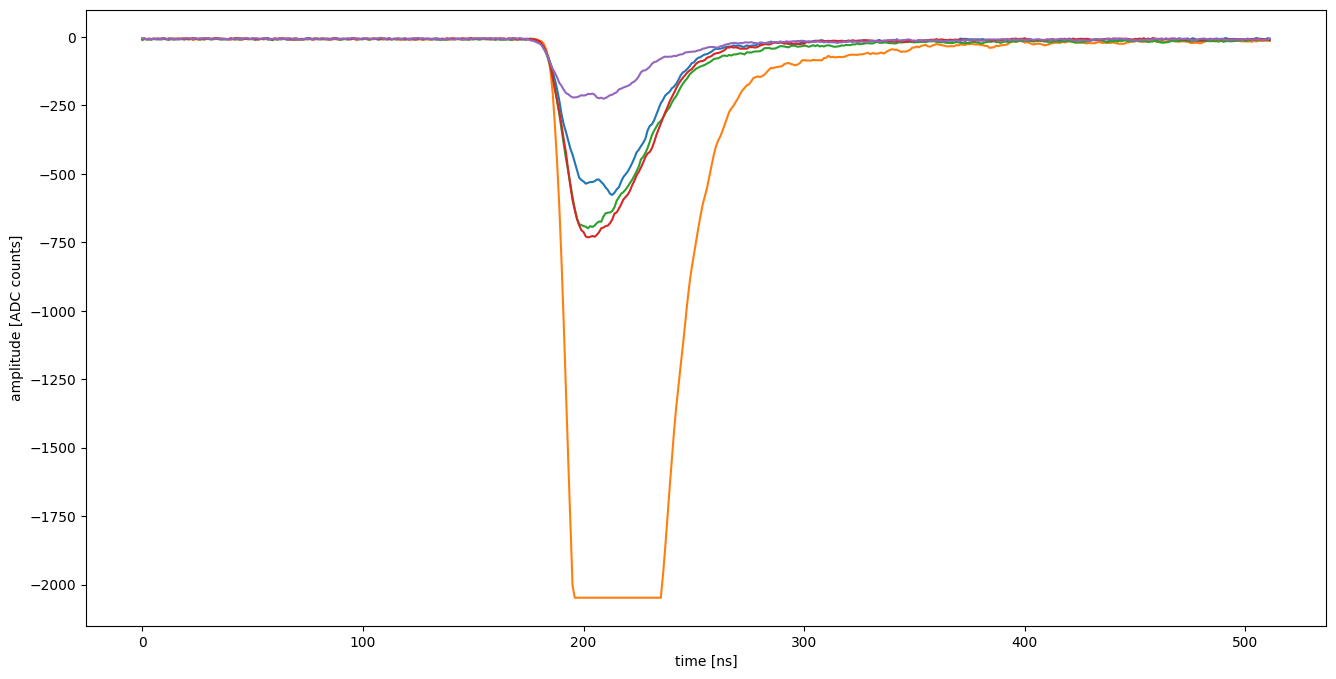

In [35]:
# Select only the pulse shape part of the data
pulses = data_raw[:,2:]
# Prepare a figure and plot some pulses
print(pulses.shape)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(pulses[0])
ax.plot(pulses[10])
ax.plot(pulses[100])
ax.plot(pulses[1000])
ax.plot(pulses[10000])
ax.set_xlabel("time [ns]")
ax.set_ylabel("amplitude [ADC counts]")
plt.show()

We will now extract the flight times.

In [36]:
times = data_raw[:,1]
print('Flight times between', times.min(), 'and', times.max(), 'nanoseconds.')

Flight times between -507.181 and 405.905 nanoseconds.


Negative flight times (also called times of flight, tof) are okay (for random coincidences), but we will restrict their range before plotting:

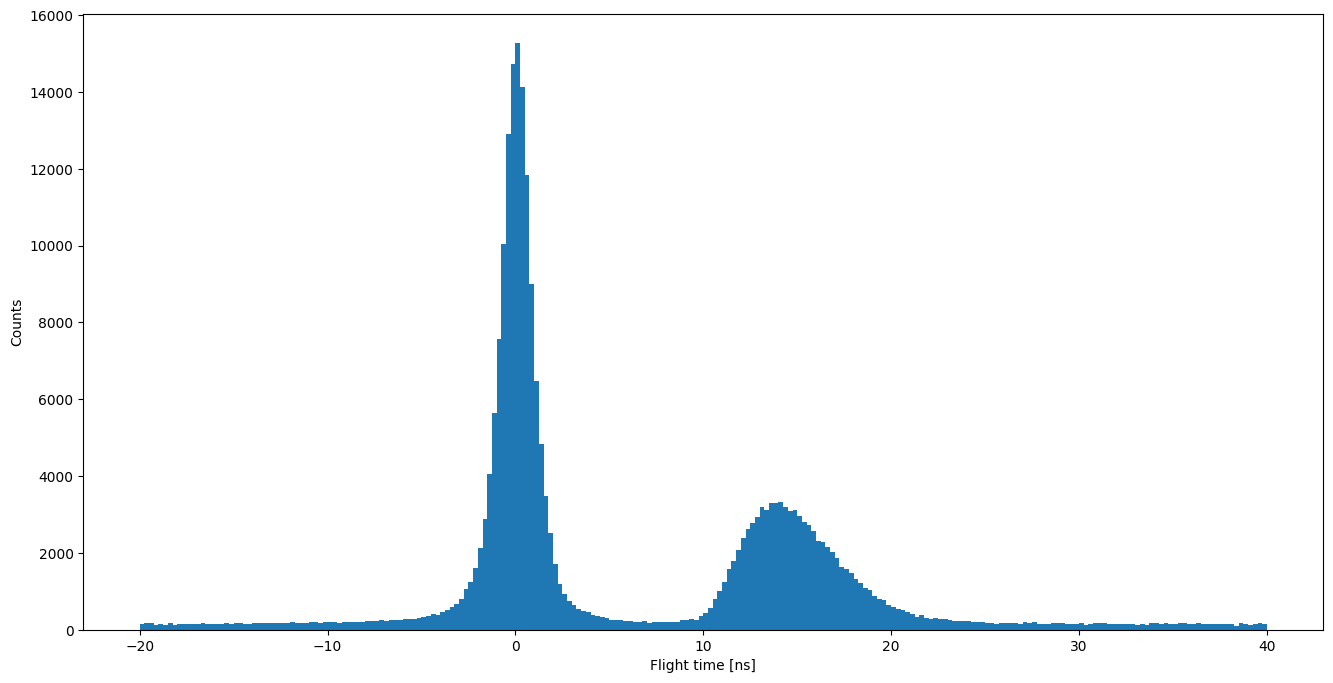

In [37]:
min_tof = -20
max_tof = 40
times = times[(times>=min_tof) & (times<=max_tof)]
# Now create a figure
fig, ax  = plt.subplots(figsize=(16,8))
ax.hist(times, bins=240)   # high resolution: 4 bins per nanosecond
ax.set_xlabel('Flight time [ns]')
ax.set_ylabel('Counts')
fig.show()

The flight time spectrum shows a gamma peak at around 0 ns and a neutron peak at around 10 to 20 ns.
You can now define flight time ranges within which you will accept gammas and neutrons. Please adjust the numbers below according to your data and your liking.
During the exercise class, we will discuss how the choice of the limits affects your results.

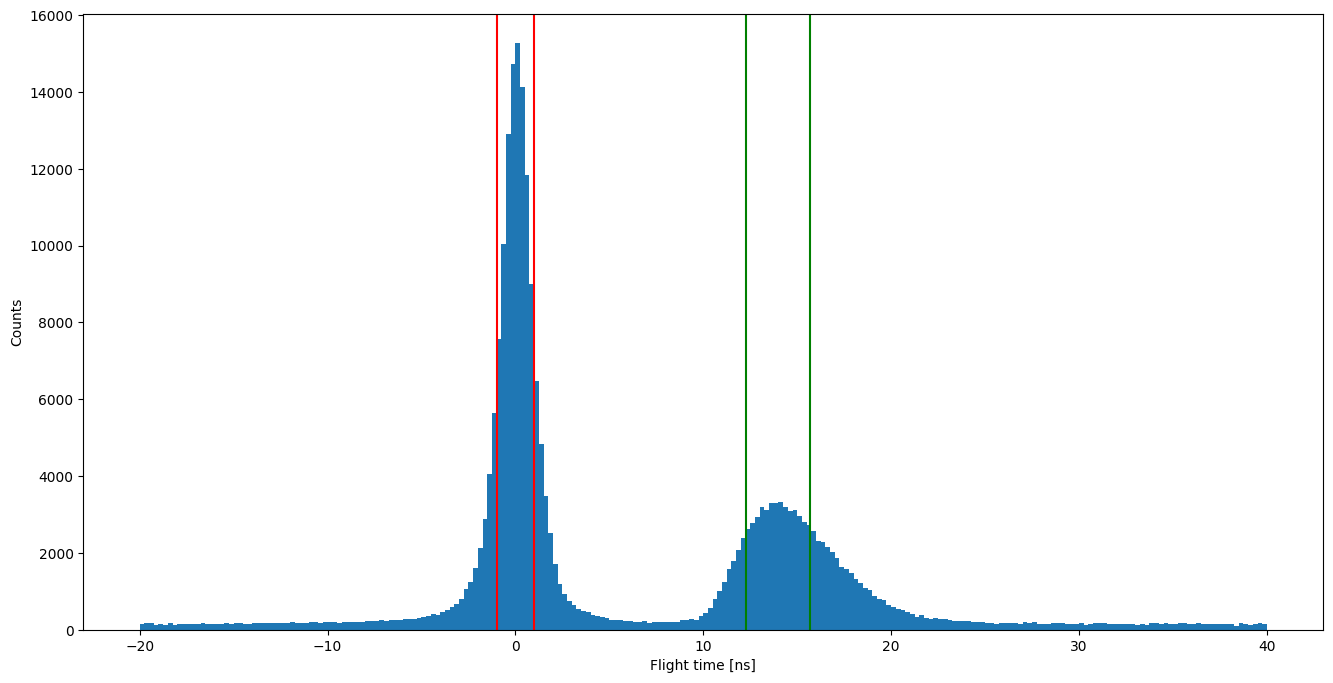

In [137]:
gamma_min_tof =-1
gamma_max_tof =1
neutron_min_tof =12.3
neutron_max_tof =15.7

min_tof = -20
max_tof = 40
times = times[(times>=min_tof) & (times<=max_tof)]
# Now create a figure
fig, ax  = plt.subplots(figsize=(16,8))
ax.hist(times, bins=240)   # high resolution: 4 bins per nanosecond
ax.set_xlabel('Flight time [ns]')
ax.set_ylabel('Counts')
ax.axvline(x=gamma_min_tof, color="r")
ax.axvline(x=gamma_max_tof, color="r")
ax.axvline(x=neutron_min_tof, color="g")
ax.axvline(x=neutron_max_tof, color="g")
fig.show()

In [138]:


gammadata = data_raw[(data_raw[:,1] >= gamma_min_tof) & (data_raw[:,1] <= gamma_max_tof)]
gammapulses = gammadata[:,2:]
print('Gammas:  ', gammapulses.shape)

neutrondata = data_raw[(data_raw[:,1] >= neutron_min_tof) & (data_raw[:,1] <= neutron_max_tof)]
neutronpulses = neutrondata[:,2:]
print('Neutrons:', neutronpulses.shape)



Gammas:   (95508, 512)
Neutrons: (41441, 512)


You now have two arrays with pulse shapes, one with only gammas (according to the flight times) and one with only neutrons (again, according to the flight times). Each array contains a large number of pulse shapes, each pulse consists of 512 detector readings.

Let's start preparing the data for the training of a neural network.



## Note
After plotting pulses I notice that most of the action seems to happen between 200 ns and 300 ns. I will introduce sample truncation as hyperparameter.

In [139]:

sample_trunc=(150, 480)

In [140]:
# make a combined data set containing both pulse types
data = np.vstack((gammapulses, neutronpulses))
data=data[:,sample_trunc[0]:sample_trunc[1]]
labels = np.zeros(len(data), dtype=int)
labels[:len(gammapulses)] = 1
# gammas are labelled as 1, and neutrons are labelled as 0

# normalize the data
scaler=Scaler().fit(data)
data=scaler.transform(data)

samples_per_pulse = len(data[0])

# in case you use a CNN architecture, we need to add an empty axis.
data = data[:,:, np.newaxis]

# before we split up the dataset into training, validation and test data set, we need to shuffle the events
# otherwise we end up having only one type of event in our validation and test data sets.
np.random.seed(1234)
shuffle_indices = np.arange(0, len(data), dtype=int)
np.random.shuffle(shuffle_indices)
data = data[shuffle_indices]
labels = labels[shuffle_indices]

num_datapoints=labels.shape[0]
train_split=num_datapoints//2
test_split=num_datapoints//4

data_train=data[:train_split]
labels_train=labels[:train_split]
data_validation=data[train_split:-test_split]
labels_validation=labels[train_split:-test_split]
data_test=data[:test_split]
labels_test=labels[:test_split]

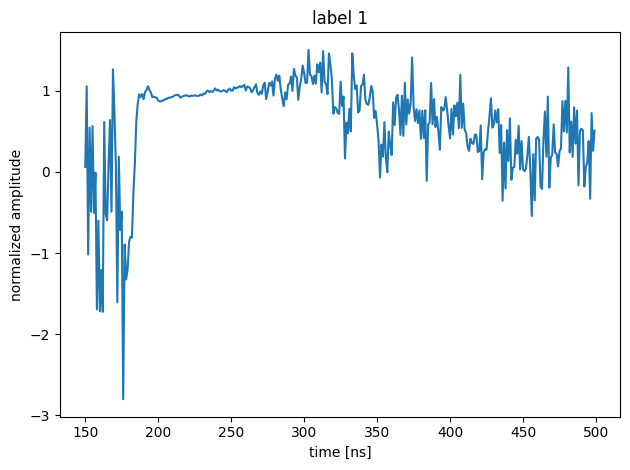

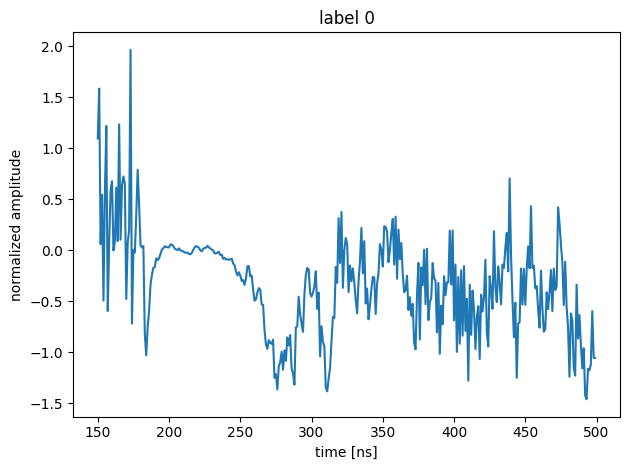

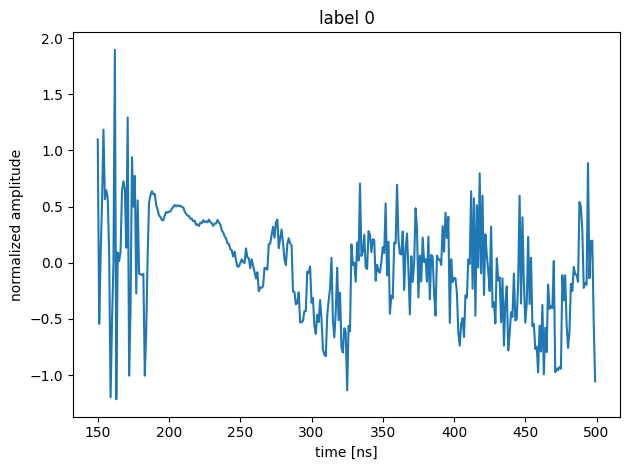

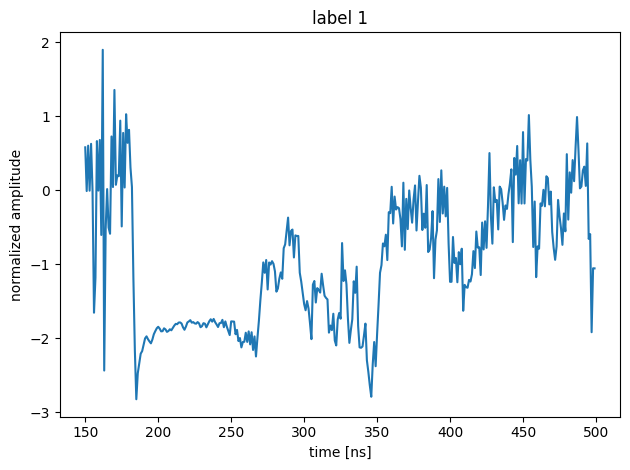

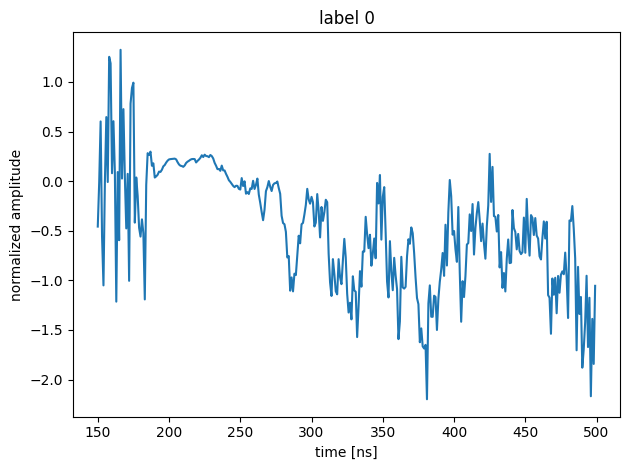

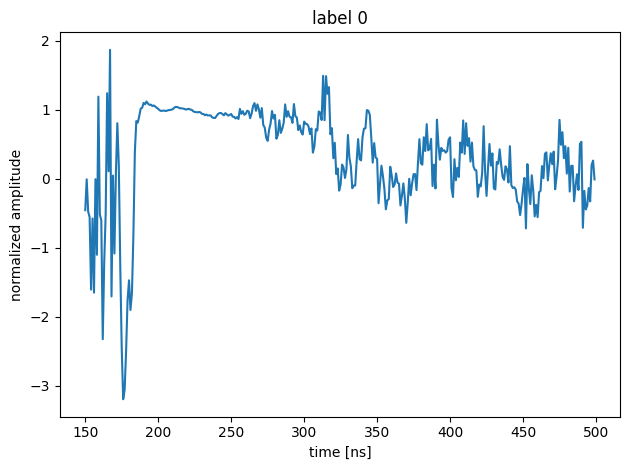

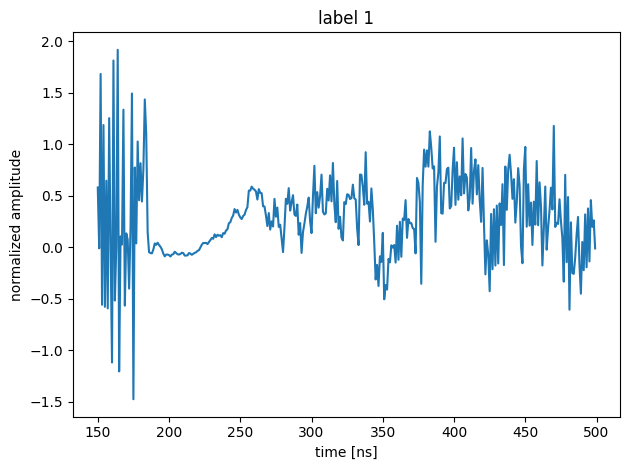

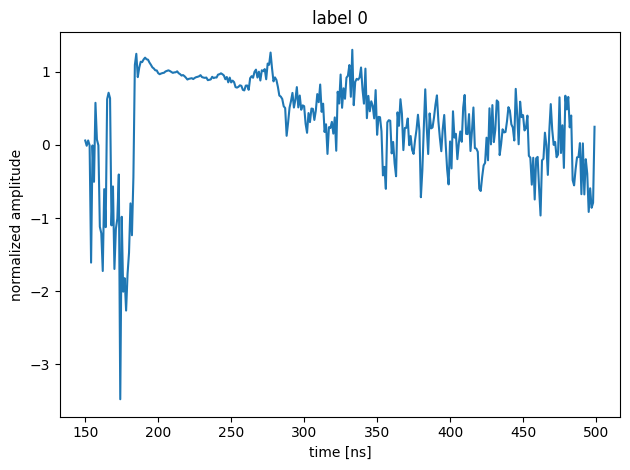

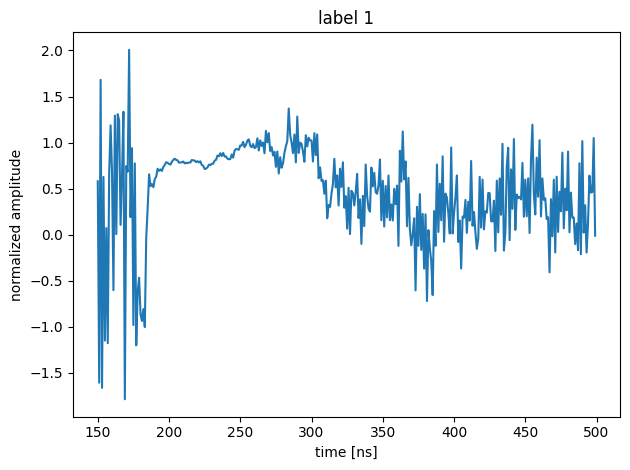

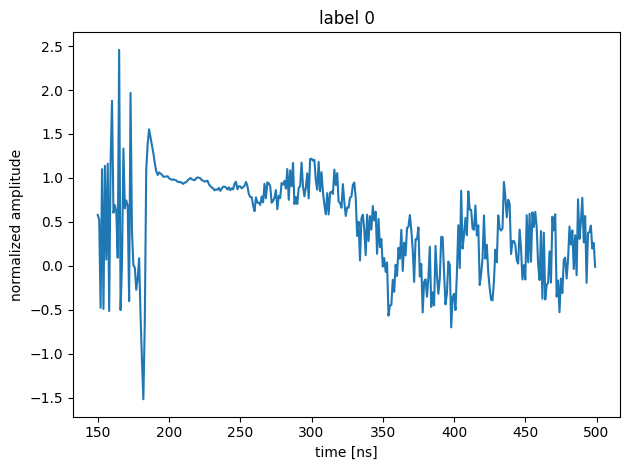

In [69]:
# plot a few events
for i in range(10):
    fig, ax = plt.subplots(1, 1)
    ax.plot(range(sample_trunc[0], sample_trunc[1]),data_train[i,:,0])
    ax.set_title(f"label {labels_train[i]}")
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("normalized amplitude")
    fig.tight_layout()
    plt.show()
    plt.close("all")

In [43]:
import os
path = os.path.join('saved_models')
if not os.path.exists(path):
    os.makedirs(path)

Now we can define the neural network and train it.

In [44]:
# first the usual imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten, Dropout
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, Input, Flatten, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle


In [130]:
def plot_confusion(true, predict, label_names, title=None):
    num_labels=len(label_names)
    C = np.histogram2d(true, predict, bins=np.linspace(0, num_labels, num_labels+1))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    if title:
      plt.title(title)
    plt.xticks(range(num_labels), label_names, rotation="vertical")
    plt.yticks(range(num_labels), label_names)
    for x in range(num_labels):
        for y in range(num_labels):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")

In [141]:

model = Sequential()


# if you use a convlutional layer first, you can directly use the input data
model.add(Conv1D(16, kernel_size=(7), padding="same", activation="relu", input_shape=(samples_per_pulse, 1)))


model.add(Flatten())
model.add(Dense(2, activation="softmax"))
model.name="best_model_13"

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "best_model_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)                   │ (None, 330, 16)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 5280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │          10,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,690 (41.76 KB)

 Trainable params: 10,690 (41.76 KB)

 Non-trainable params: 0 (0.00 B)

None


In [142]:
#Convert labels to one-hot encodint
labels_train_onehot = tf.keras.utils.to_categorical(labels_train, 2)
labels_test_onehot = tf.keras.utils.to_categorical(labels_test, 2)
labels_validation_onehot = tf.keras.utils.to_categorical(labels_validation, 2)

In [143]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=["accuracy"]
)

model.fit(
    data_train, labels_train_onehot,
    batch_size=20,
    epochs=20, # train at least for 20 epochs
    verbose=1,
    validation_data=(data_validation, labels_validation_onehot),
    callbacks=[
        tf.keras.callbacks.CSVLogger(f"history_{model.name}.csv"),
        keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1E-5),
        keras.callbacks.EarlyStopping(patience=4, verbose=1)])

Epoch 1/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9763 - loss: 0.1162 - val_accuracy: 0.9831 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 2/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9824 - loss: 0.0924 - val_accuracy: 0.9820 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 3/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9823 - loss: 0.0916 - val_accuracy: 0.9827 - val_loss: 0.0945 - learning_rate: 0.0010
Epoch 4/20
3411/3424 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0880
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9830 - loss: 0.0880 - val_accuracy: 0.9829 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 5/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9826 - loss: 0.0870 - val_accuracy: 0.9829 - val_loss: 0.0889 - learning_rate: 6.7000e-04
Epoch 6/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.

## Note
After training the model with a single layer I want to evalute it. To evaluate I use the **validation set**, this is because I consider this model to be a contender for my final model. If I compared the performance of the single layer and multilayer model using the test set and then made any tweaks to my final model after that, *I would achieve a biased estimate of the "unseen data" accuracy by using test accuracy as estimate*. Since I want to make descisions on how to tweak the model based on this comparison, I will leave the test data untouched.

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


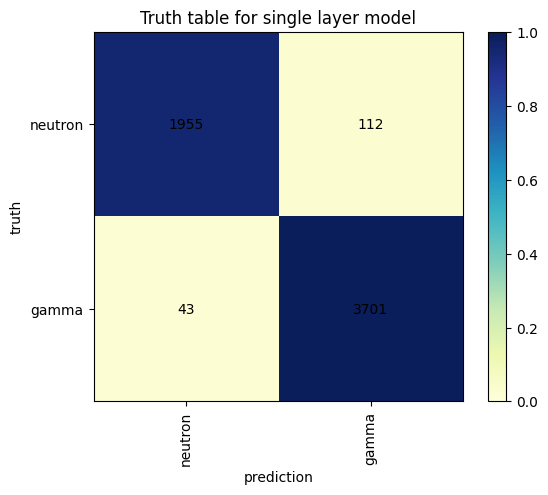

In [28]:
prediction=model.predict(data_validation, batch_size=128)
prediction=np.argmax(prediction, axis=1) #convert from one-hot to label

plot_confusion(labels_validation, prediction, ["neutron", "gamma"], title="Truth table for single layer model")

In [29]:
val_acc=np.mean(np.equal(prediction, labels_validation))
print(val_acc)

0.973326449836517


Very nice! Note that this was with tof_gamma in [-2.8, 2.8], tof_neut in [10.5, 19] and sample_trunc of [150, 500].

Now I do the same for a multilayered net.

414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.9727451425115294


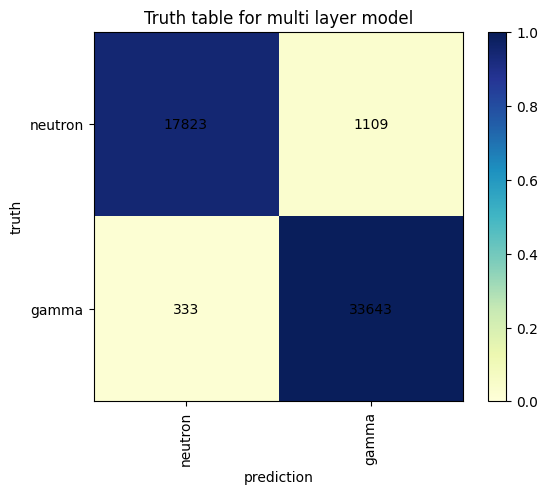

In [57]:
prediction=model.predict(data_validation, batch_size=128)
prediction=np.argmax(prediction, axis=1) #convert from one-hot to label

plot_confusion(labels_validation, prediction, ["neutron", "gamma"], title="Truth table for multi layer model")

val_acc=np.mean(np.equal(prediction, labels_validation))
print(val_acc)

No improvement. (same hyperparameters as above)

Now try to find the best possible

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
0.9822419533851277


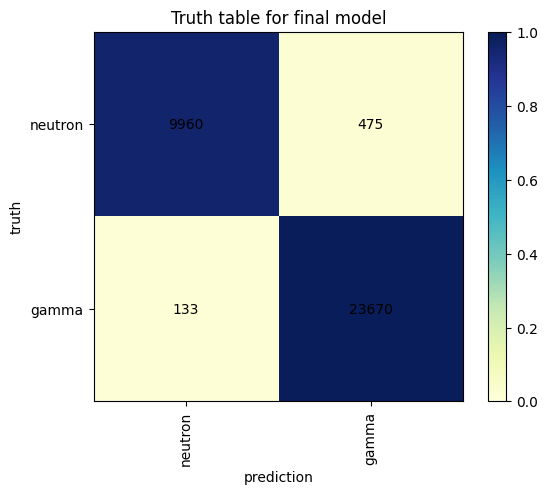

In [144]:
prediction=model.predict(data_validation, batch_size=128)
prediction=np.argmax(prediction, axis=1) #convert from one-hot to label

plot_confusion(labels_validation, prediction, ["neutron", "gamma"], title="Truth table for final model")

val_acc=np.mean(np.equal(prediction, labels_validation))
print(val_acc)

Now with our final model we can estimate the new data error

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.9841983818675701


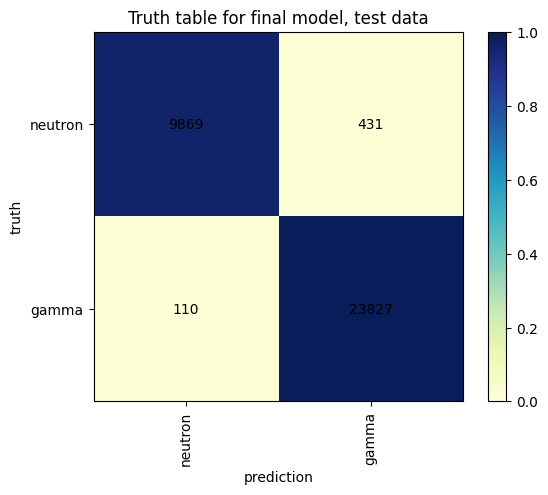

In [145]:
prediction=model.predict(data_test, batch_size=128)
prediction=np.argmax(prediction, axis=1) #convert from one-hot to label

plot_confusion(labels_test, prediction, ["neutron", "gamma"], title="Truth table for final model, test data")

test_acc=np.mean(np.equal(prediction, labels_test))
print(test_acc)

The final model truncates samples a bit earlier (480 instead of 500), also to improve accuracy we narrow down which data to label as neutron or gamma. This means that we end up with less data but the data that we have has a higher rate of correct labeling. In all data there is still some noice from background radiation which causes misslabeled data to be included in the dataset. This includes the test set meaning that our estimation of accuracy is not the accuracy of classifying neutron/gamma, rather it is the accuracy of classifying data which is labeled neutron/gamma with this setup. Now consider the graph from earlier:

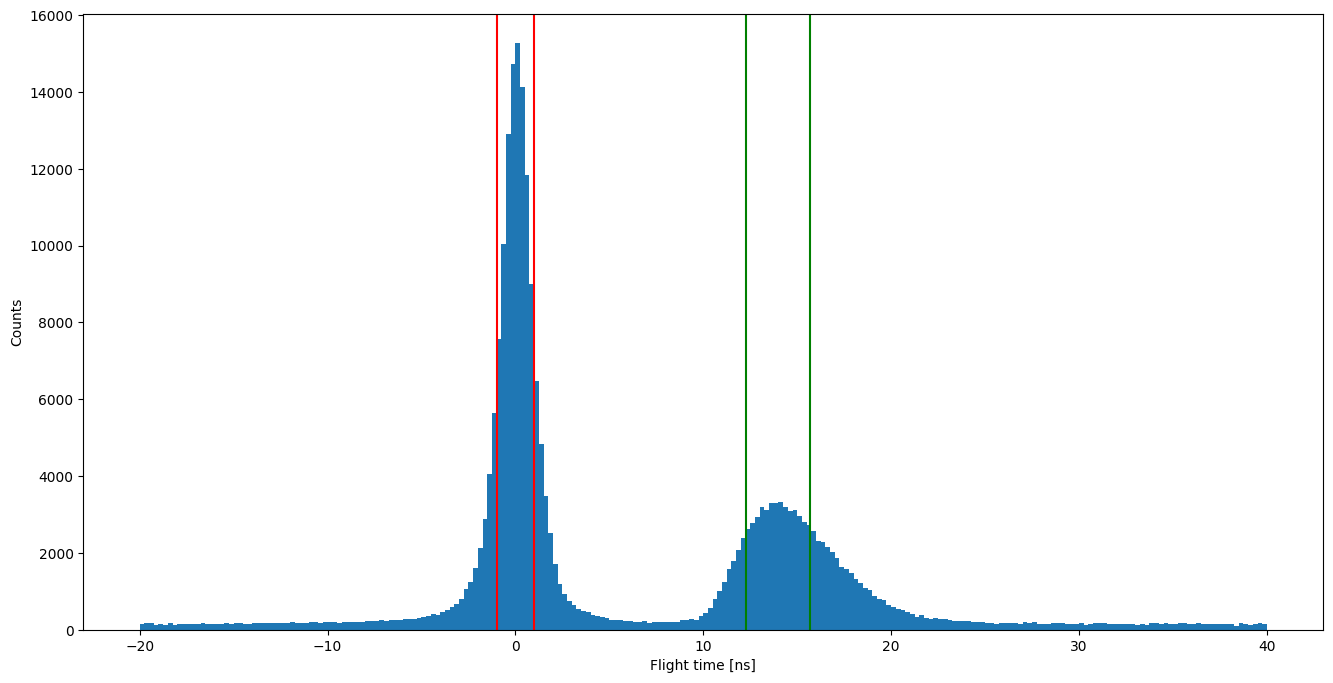

For a rough estimation of this error, assume that 100 counts per time bin is noice. Here assume that 30 of these are correctly labeled by accident (background gamma is labeled as gamma altough it does not originate from our source). This leaves 70 misslabeled counts per bin. In our bins we seem to have on average 11000 counts/bin for gamma and 2700 counts/bin for neutron. The ratio of misslabeled to total data for them are thus 0.6% for gamma and 2.6% for neutrons. I estimate 1% misslabeling for a particle in general.

This means that the truth table is incorrect and some true classifications belong in the missclassifaction category. However this also goes the other way, some of the missclassified data may actually have been correctly classified, but incorrectly labeled. Consider the different cases of misslabeled data: if the data is something else than neutron or gamma it would be evenly distributed in the truth table since it should be randomly labeled gamma or neutron, if it is a missclassified neutron/gamma it can either be correctly classified by the network (\~98%) and end up in the missclassified category or end up in the correctly classified category by accident. If we say that the second option is the case for half of the missclassifications then 50% of the missclassifications are actually correctly classified and the actual accuracy would be approximately 98.4+1.6*0.5~99%. This however assumes that there is no distinction/bias between pulses from the source and pulses from background radion in terms of how the pulse looks.